In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import cell2location
import scvi
import torch
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.backends.backend_pdf as mpdf
import warnings
sys.path.append("/home/biolab/Projects/LAMs_wd/scripts")
warnings.filterwarnings('ignore')
data_type = 'float32'
from visium_qc_and_visualisation import read_and_qc
from config import lung_config

/home/ozlemtuna/miniconda3/envs/jupyter_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ozlemtuna/miniconda3/envs/jupyter_env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/ozlemtuna/miniconda3/envs/jupyter_env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
o_sig_matrix = pd.read_csv("/home/biolab/Projects/LAMs_wd/data/signature_matrix_sq_24_cell_type_renamed.csv", index_col=0)
o_sig_matrix

,Stromal,Endothelial_cell,Alveolar_cell_type_1,Alveolar_cell_type_2,transitional_club/AT2,other,Macrophage_alveolar,NK_cell,Mast_cell,Club,...,T_cell_CD8,Tumor_cells,T_cell_CD4,Plasma_cell,cDC1,cDC2,B_cell,Neutrophils,DC_mature,T_cell_regulatory
CDH11,429.229015,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
DOCK9,1.000000,473.570096,1.000000,59.077085,1.000000,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
CLIC3,1.000000,1.000000,997.781399,212.359701,237.847267,1.000000,1.0,383.494818,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
CCNG2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,102.533423,1.0,...,1.000000,1.000000,1.000000,1.000000,52.746868,56.873905,1.000000,1.0,314.848934,1.000000
PCDH17,1.000000,560.654133,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CDKN3,1.000000,1.000000,1.000000,1.000000,1.000000,262.356384,1.0,1.000000,1.000000,1.0,...,1.000000,93.431375,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
CAMK4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,...,175.347016,1.000000,213.361118,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,106.219895
WIF1,1.000000,1.000000,1.000000,209.595993,1.000000,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
TMEM156,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.000000,76.778009,119.800078,1.000000,1.000000,167.259363,1.0,1.000000,1.000000


In [3]:
def run_cell2loc(ifolder, environment):
    seed = 42
    torch.manual_seed(seed)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    outDir = f"/home/biolab/Projects/LAMs_wd/results/cell2location/spatial_model_SC_Y_sig_matrix_adeno_LUSC_patients/"
    regDir = f"/home/biolab/Projects/LAMs_wd/data/E-MTAB-13530/{ifolder}/cell2location/regression_model/"
    import os
    os.makedirs(outDir + environment, exist_ok=True)

    # Pick up the scRNA-seq gene expression model
#     adata_sc_model = sc.read_h5ad(f"{regDir}{environment}/sc.h5ad")
#     adata_sc_model = sc.read_h5ad("/media/mllab/SSD/ST/lung-master/SpatialTranscriptomics/cell2location/regression_model/Tumour/sc.h5ad")
    
#     mod = cell2location.models.RegressionModel.load(f"{regDir}{environment}", adata_sc_model)
#     adata_sc_model = mod.export_posterior(adata_sc_model, sample_kwargs={'num_samples': 1000, 'batch_size': 2500})
#     adata_sc_model.write(f"{regDir}{environment}/sc.h5ad")

    inf_aver = None
    # Export estimated expression signature in each cluster
    
    inf_aver = o_sig_matrix.copy()

    # Scale up by average sample scaling factor. This corrects for sequencing depth
    # inf_aver = inf_aver * adata_sc_model.uns["mod"]["post_sample_means"]["sample_scaling"].mean() # Need to check if this is still necessary

    # Pick up Visium
    sample_names = lung_config[environment]["spatial"]["LUSC"]
    print(sample_names)
    #inDir = "/lustre/scratch118/opentargets/opentargets/OTAR2060/nelson/data/lung/visium/samples/{}/".format(environment.lower())
    inDir = "/home/biolab/Projects/LAMs_wd/data/E-TAMB-13530/"
    slides = [read_and_qc(sample_name, path=inDir) for sample_name in sample_names]
    adata_vis = slides[0].concatenate(slides[1:], batch_key="sample", uns_merge="unique", batch_categories=sample_names, index_unique=None)
    # Mitochondria-encoded (MT) genes should be removed for spatial mapping
    # Find mitochondria-encoded (MT) genes
    adata_vis.var["MT_gene"] = [gene.startswith("MT-") for gene in adata_vis.var["SYMBOL"]]
    # Remove MT genes for spatial mapping (keeping their counts in the object)
    adata_vis.obsm["MT"] = adata_vis[:, adata_vis.var["MT_gene"].values].X.toarray()
    adata_vis = adata_vis[:, ~adata_vis.var["MT_gene"].values]
    # Reset the index for compatibility with the scRNA-seq counts
    adata_vis.var.set_index("SYMBOL", inplace=True)

    # Find shared genes and subset both anndata and reference signatures
    adata_vis.var_names_make_unique()
    
    inf_aver_index = np.array(inf_aver.index, dtype=str)
    adata_vis_var_names = np.array(adata_vis.var_names, dtype=str)
    intersect = np.intersect1d(adata_vis_var_names, inf_aver_index)
    #intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
    #adata_vis = adata_vis[:, intersect] # This doesn't work -- think there's some incompatibility between ScanPy and AnnData versions. Use the line below instead
    adata_vis = adata_vis[:, adata_vis.var.index.isin(intersect)].copy()
    inf_aver = inf_aver.loc[intersect, :]
    # Reindex for cell2location
    inf_aver = inf_aver.reindex(adata_vis.var.index)

    # Save on memory
#     del adata_sc_model
#     del mod

    # Training cell2location
    cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")
    mod = cell2location.models.Cell2location(adata_vis,
                                             cell_state_df=inf_aver,
                                             detection_alpha=200, # Controls the normalisation of the within-experiment variation of the RNA detection (default value for now)
                                             N_cells_per_location=8
                                             )
    '''
                                             **model_kwargs={
                                                # Prior on the number of cells, cell types and co-located groups. Hyperparameter inputs go here
                                                "cell_number_prior": {
                                                    # - N - the expected number of cells per location:
                                                    "cells_per_spot": 8,
                                                    # - A - the expected number of cell types per location:
                                                    "factors_per_spot": 9,
                                                    # - Y - the expected number of co-located cell type groups per location
                                                    "combs_per_spot": 5
                                                },
                                                # Prior beliefs on the sensitivity of spatial technology:
                                                "gene_level_prior": {
                                                    # Prior on the mean
                                                    "mean": 0.5,
                                                    # Prior on standard deviation
                                                    # A good choice of this value should be at least 2 times lower that the mean
                                                    "sd": 0.15
                                                }
                                             }
                                             )
    '''

    # Try 2500 batches initially, rather than training on the entire data-set
    mod.train(batch_size=2500, train_size=1, max_epochs=3000)
    mod.save(f"{outDir}{environment}", overwrite=True)
    adata_vis = mod.export_posterior(adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': 2500})
    adata_vis.write(f"{outDir}{environment}/sp_our_sig_matrix_all_cts_{environment}.h5ad")

    train_performance = mod.history["elbo_train"]
    train_performance.plot(logy=True)
    plt.xlabel("Training epochs")
    plt.ylabel("-ELBO loss")
    plt.title(f"Lung ({environment})")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig(f"{outDir}/ELBO_Cell2location_{environment}.png")
    plt.close()

In [4]:
run_cell2loc("dataset", "Background")

['spaceranger110_count_40751_OTAR_LNGsp10782315_GRCh38-2020-A', 'spaceranger110_count_40751_OTAR_LNGsp10782314_GRCh38-2020-A', 'spaceranger110_count_40612_OTAR_LNGsp10782313_GRCh38-2020-A', 'spaceranger110_count_40612_OTAR_LNGsp10782312_GRCh38-2020-A']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3000/3000: 100%|██████████| 3000/3000 [45:23<00:00,  1.26it/s, v_num=1, elbo_train=3.19e+6]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Sampling global variables, sample: 100%|██████████| 999/999 [00:27<00:00, 35.79it/s]


In [27]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [28]:
ids = {'spaceranger110_count_38385_OTAR_LNGsp10206160_GRCh38-2020-A': 'P17_T2',
 'spaceranger110_count_36209_OTAR_LNGsp9476038_GRCh38-2020-A': 'P10_T1',
 'spaceranger110_count_39586_OTAR_LNGsp10391238_GRCh38-2020-A': 'P24_T2',
 'spaceranger110_count_40612_OTAR_LNGsp10782313_GRCh38-2020-A': 'P19_B2',
 'spaceranger110_count_39586_OTAR_LNGsp10391237_GRCh38-2020-A': 'P24_T1',
 'spaceranger110_count_36209_OTAR_LNGsp9476039_GRCh38-2020-A': 'P10_T2',
 'spaceranger110_count_38262_OTAR_LNGsp10206166_GRCh38-2020-A': 'P16_T2',
 'spaceranger110_count_38385_OTAR_LNGsp10206159_GRCh38-2020-A': 'P17_T1',
 'spaceranger110_count_36209_OTAR_LNGsp9476040_GRCh38-2020-A': 'P10_T3',
 'spaceranger110_count_38385_OTAR_LNGsp10206158_GRCh38-2020-A': 'P15_T2',
 'spaceranger110_count_38385_OTAR_LNGsp10206157_GRCh38-2020-A': 'P15_T1',
 'spaceranger110_count_38384_OTAR_LNGsp10206164_GRCh38-2020-A': 'D1_2',
 'spaceranger110_count_39586_OTAR_LNGsp10391236_GRCh38-2020-A': 'P25_T2',
 'spaceranger110_count_36209_OTAR_LNGsp9476041_GRCh38-2020-A': 'P10_T4',
 'spaceranger110_count_38384_OTAR_LNGsp10206161_GRCh38-2020-A': 'D2_1',
 'spaceranger110_count_40951_OTAR_LNGsp10922366_GRCh38-2020-A': 'P17_B2',
 'spaceranger110_count_40951_OTAR_LNGsp10922365_GRCh38-2020-A': 'P17_B1',
 'spaceranger110_count_36210_OTAR_LNGsp9476045_GRCh38-2020-A': 'P11_T4',
 'spaceranger110_count_39586_OTAR_LNGsp10391235_GRCh38-2020-A': 'P25_T1',
 'spaceranger110_count_40751_OTAR_LNGsp10782317_GRCh38-2020-A': 'P10_B2',
 'spaceranger110_count_40612_OTAR_LNGsp10782311_GRCh38-2020-A': 'P15_B2',
 'spaceranger110_count_40952_OTAR_LNGsp10922370_GRCh38-2020-A': 'P25_B2',
 'spaceranger110_count_40612_OTAR_LNGsp10782312_GRCh38-2020-A': 'P19_B1',
 'spaceranger110_count_40951_OTAR_LNGsp10922368_GRCh38-2020-A': 'P16_B2',
 'spaceranger110_count_36210_OTAR_LNGsp9476044_GRCh38-2020-A': 'P11_T3',
 'spaceranger110_count_40751_OTAR_LNGsp10782314_GRCh38-2020-A': 'P11_B1',
 'spaceranger110_count_40751_OTAR_LNGsp10782316_GRCh38-2020-A': 'P10_B1',
 'spaceranger110_count_40952_OTAR_LNGsp10922371_GRCh38-2020-A': 'P24_B1',
 'spaceranger110_count_40612_OTAR_LNGsp10782310_GRCh38-2020-A': 'P15_B1',
 'spaceranger110_count_38262_OTAR_LNGsp10206168_GRCh38-2020-A': 'P19_T2',
 'spaceranger110_count_38262_OTAR_LNGsp10206167_GRCh38-2020-A': 'P19_T1',
 'spaceranger110_count_40951_OTAR_LNGsp10922367_GRCh38-2020-A': 'P16_B1',
 'spaceranger110_count_38384_OTAR_LNGsp10206163_GRCh38-2020-A': 'D1_1',
 'spaceranger110_count_38384_OTAR_LNGsp10206162_GRCh38-2020-A': 'D2_2',
 'spaceranger110_count_40952_OTAR_LNGsp10922369_GRCh38-2020-A': 'P25_B1',
 'spaceranger110_count_38262_OTAR_LNGsp10206165_GRCh38-2020-A': 'P16_T1',
 'spaceranger110_count_36210_OTAR_LNGsp9476042_GRCh38-2020-A': 'P11_T1',
 'spaceranger110_count_36210_OTAR_LNGsp9476043_GRCh38-2020-A': 'P11_T2',
 'spaceranger110_count_40751_OTAR_LNGsp10782315_GRCh38-2020-A': 'P11_B2',
 'spaceranger110_count_40952_OTAR_LNGsp10922372_GRCh38-2020-A': 'P24_B2'}

In [38]:

env = "cell2location/spatial_model_SC_Y_sig_matrix_adeno_LUSC_patients/Background"
folder = "/home/biolab/Projects/LAMs_wd/results/"
cell2location_res_all_cts = sc.read_h5ad(f"{folder}{env}/sp_our_sig_matrix_all_cts_Background.h5ad")

In [39]:
patients = list(cell2location_res_all_cts.uns["spatial"].keys())

#dict to sort the ouput for each patient
slices = {}

for patient in patients:
    
    slices [patient] = {}
    #get  specific spots for that patient
    spots = [s for s in cell2location_res_all_cts.obs_names if patient in s]
    
    slice_res = cell2location_res_all_cts[spots].copy()
    #slice_res.obs_names = [s.replace(f"{patient}_","") for s in slice_res.obs_names]
    
    #retireve the cell abundance matrix
    weights = slice_res.obsm["q05_cell_abundance_w_sf"]
    weights.columns = [c.replace("q05cell_abundance_w_sf_", "") for c in weights]

    
    slices[patient]["w"] = weights.copy()
    #add a column that contains the cell type id with the highest weight
    slices[patient]["w"]['max_w'] = slices[patient]["w"].idxmax(axis=1)
    
    #add two columns that consist of the spot's spatial data
    slices[patient]["w"]["x"] = slice_res.obsm["spatial"][:,0]
    slices[patient]["w"]["y"] = slice_res.obsm["spatial"][:,1]

In [40]:
#in this section, i check the version where cell2location was run using all 24 cell types.
#then, i count how many spots per patient have a high abundance assigned to a macrophage cell type.
#i also store these ids in a list named: spots
macro_spots = {}
spots = set()
for patient in patients:
    macro_spots[patient] = slices[patient]["w"][slices[patient]["w"]["max_w"].isin(["Macrophage_alveolar", "Macrophage"])]
    print(ids[patient], ":", macro_spots[patient].shape[0])
    spots = spots.union(set(macro_spots[patient].index))

P19_B1 : 84
P19_B2 : 77
P11_B1 : 432
P11_B2 : 316


In [41]:
len(spots)

909

In [52]:
# Clean up the env string to avoid using directory-like structures
env_cleaned = env.strip("/").replace("/", "_")  # Replace slashes with underscores

# Now write to a file with a valid name
with open(f"luad_macrophage_spots_{env_cleaned}.txt", "w") as o:
    for spot in spots:
        o.write(f"{spot}\n")

In [48]:
if not os.path.exists(f"output/{env}/deconv_1/"):
    os.makedirs(f"output/{env}/deconv_1/")
for patient in patients:
    slices[patient]["w"].to_csv(f"output/{env}/deconv_1/{ids[patient]}_deconv_1_cell_abundance.xlsx")

In [44]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import cell2location
import scvi
import torch
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.backends.backend_pdf as mpdf
import warnings
sys.path.append("/home/biolab/Projects/LAMs_wd/scripts")
warnings.filterwarnings('ignore')
data_type = 'float32'
from visium_qc_and_visualisation import read_and_qc
from config import lung_config

In [61]:
env = "Background"

In [62]:

o_sig_matrix = pd.read_csv("/home/biolab/Projects/LAMs_wd/data/squamous_cell_lung_carcinoma_macs_cibersortx_sig_mtrx_renamed.csv", index_col=0)
o_sig_matrix

,RTM_TAMs,Prolif_TAMs,Angio_TAMs,LA_TAMs,IFN_TAMs,Inflam_TAMs,Reg_TAMs
AAMP,95.017140,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
DOK1,96.638317,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
DAPP1,1.000000,1.0,1.000000,1.000000,125.162076,1.000000,1.000000
RO60,1.000000,1.0,1.000000,1.000000,125.961147,1.000000,92.823520
MSRA,84.601275,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...
SGMS2,126.637945,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
IFI44,1.000000,1.0,1.000000,1.000000,157.949715,1.000000,88.638150
PTOV1,1.000000,1.0,68.246255,69.783008,1.000000,128.428181,1.000000
ZNF22,1.000000,1.0,1.000000,1.000000,104.335292,1.000000,1.000000


In [63]:
with open(f"/home/biolab/Projects/LAMs_wd/results/cell2location/spatial_model_SC_Y_sig_matrix_adeno_LUSC_patients/Background/luad_macrophage_spots_{env}.txt", "r") as i:
    spots = i.read().split("\n")

In [57]:
len(spots)

910

In [64]:
spots[:10]

['spaceranger110_count_40751_OTAR_LNGsp10782314_GRCh38-2020-A_AAGCCGAAGCGGTTTA-1',
 'spaceranger110_count_40612_OTAR_LNGsp10782312_GRCh38-2020-A_TCTAGCATCTTCGATG-1',
 'spaceranger110_count_40751_OTAR_LNGsp10782315_GRCh38-2020-A_CAGATACTAACATAGT-1',
 'spaceranger110_count_40612_OTAR_LNGsp10782312_GRCh38-2020-A_GCTGGCGGCGCATGCT-1',
 'spaceranger110_count_40612_OTAR_LNGsp10782312_GRCh38-2020-A_ATAATAGCTGTTGAAT-1',
 'spaceranger110_count_40612_OTAR_LNGsp10782313_GRCh38-2020-A_TCCCAAAGACGAAGGA-1',
 'spaceranger110_count_40751_OTAR_LNGsp10782314_GRCh38-2020-A_GACCGTCAGGTCGTGA-1',
 'spaceranger110_count_40751_OTAR_LNGsp10782314_GRCh38-2020-A_CGGCTGCAAGATTAAG-1',
 'spaceranger110_count_40751_OTAR_LNGsp10782314_GRCh38-2020-A_TGAGCTTTAATGACGC-1',
 'spaceranger110_count_40612_OTAR_LNGsp10782312_GRCh38-2020-A_GAAGGAGTCGAGTGCG-1']

In [67]:
def run_cell2loc(ifolder, environment):
    seed = 42
    torch.manual_seed(seed)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    outDir = f"/home/biolab/Projects/LAMs_wd/results/cell2location/cell2location_macs/"
    regDir = f"/home/biolab/Projects/LAMs_wd/data/E-MTAB-13530/{ifolder}/cell2location/regression_model/"
 

    inf_aver = None
    # Export estimated expression signature in each cluster
    
    inf_aver = o_sig_matrix.copy()

    # Scale up by average sample scaling factor. This corrects for sequencing depth
    # inf_aver = inf_aver * adata_sc_model.uns["mod"]["post_sample_means"]["sample_scaling"].mean() # Need to check if this is still necessary

    # Pick up Visium
    if env == "Background":
        sample_names = lung_config[environment]["spatial"]["LUSC"]
    else:
        sample_names = lung_config[environment]["spatial"]
    print(sample_names)
    
    ####
    #assign you path here, where your patients' data are located
    ############################
    inDir = "/home/biolab/Projects/LAMs_wd/data/E-TAMB-13530/"
    ########################################################################
    
    slides = [read_and_qc(sample_name, path=inDir) for sample_name in sample_names]
    slides_ = []
    
    #now here i select a subset of spots
    for slide in slides:
        slides_.append(slide[list(set(slide.obs_names).intersection(spots))])
    slides = slides_
    
    print(slides)
    
    
    adata_vis = slides[0].concatenate(slides[1:], batch_key="sample", uns_merge="unique", batch_categories=sample_names, index_unique=None)

    # Mitochondria-encoded (MT) genes should be removed for spatial mapping
    # Find mitochondria-encoded (MT) genes
    adata_vis.var["MT_gene"] = [gene.startswith("MT-") for gene in adata_vis.var["SYMBOL"]]
    # Remove MT genes for spatial mapping (keeping their counts in the object)
    adata_vis.obsm["MT"] = adata_vis[:, adata_vis.var["MT_gene"].values].X.toarray()
    adata_vis = adata_vis[:, ~adata_vis.var["MT_gene"].values]
    # Reset the index for compatibility with the scRNA-seq counts
    adata_vis.var.set_index("SYMBOL", inplace=True)

    # Find shared genes and subset both anndata and reference signatures
    adata_vis.var_names_make_unique()
    
    inf_aver_index = np.array(inf_aver.index, dtype=str)
    adata_vis_var_names = np.array(adata_vis.var_names, dtype=str)
    intersect = np.intersect1d(adata_vis_var_names, inf_aver_index)
    #intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
    #adata_vis = adata_vis[:, intersect] # This doesn't work -- think there's some incompatibility between ScanPy and AnnData versions. Use the line below instead
    adata_vis = adata_vis[:, adata_vis.var.index.isin(intersect)].copy()
    inf_aver = inf_aver.loc[intersect, :]
    # Reindex for cell2location
    inf_aver = inf_aver.reindex(adata_vis.var.index)


    # Training cell2location
    cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")
    mod = cell2location.models.Cell2location(adata_vis,
                                             cell_state_df=inf_aver,
                                             detection_alpha=200, # Controls the normalisation of the within-experiment variation of the RNA detection (default value for now)
                                             N_cells_per_location=8
                                             )
    '''
                                             **model_kwargs={
                                                # Prior on the number of cells, cell types and co-located groups. Hyperparameter inputs go here
                                                "cell_number_prior": {
                                                    # - N - the expected number of cells per location:
                                                    "cells_per_spot": 8,
                                                    # - A - the expected number of cell types per location:
                                                    "factors_per_spot": 9,
                                                    # - Y - the expected number of co-located cell type groups per location
                                                    "combs_per_spot": 5
                                                },
                                                # Prior beliefs on the sensitivity of spatial technology:
                                                "gene_level_prior": {
                                                    # Prior on the mean
                                                    "mean": 0.5,
                                                    # Prior on standard deviation
                                                    # A good choice of this value should be at least 2 times lower that the mean
                                                    "sd": 0.15
                                                }
                                             }
                                             )
    '''

    # Try 2500 batches initially, rather than training on the entire data-set
    mod.train(batch_size=2500, train_size=1, max_epochs=3000)
    mod.save(f"{outDir}{environment}", overwrite=True)
    adata_vis = mod.export_posterior(adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': 2500})
    adata_vis.write(f"{outDir}{environment}/sp_our_sig_matrix_macrophage_cts_{environment}.h5ad")

    train_performance = mod.history["elbo_train"]
    train_performance.plot(logy=True)
    plt.xlabel("Training epochs")
    plt.ylabel("-ELBO loss")
    plt.title(f"Lung ({environment})")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig(f"{outDir}{environment}/ELBO_Cell2location_{environment}.png")
    plt.close()

In [68]:
run_cell2loc("dataset", env)

['spaceranger110_count_40751_OTAR_LNGsp10782315_GRCh38-2020-A', 'spaceranger110_count_40751_OTAR_LNGsp10782314_GRCh38-2020-A', 'spaceranger110_count_40612_OTAR_LNGsp10782313_GRCh38-2020-A', 'spaceranger110_count_40612_OTAR_LNGsp10782312_GRCh38-2020-A']
[View of AnnData object with n_obs × n_vars = 316 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'
    uns: 'spatial'
    obsm: 'spatial', View of AnnData object with n_obs × n_vars = 432 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3000/3000: 100%|██████████| 3000/3000 [03:36<00:00, 11.81it/s, v_num=1, elbo_train=1.86e+5]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Sampling global variables, sample: 100%|██████████| 999/999 [00:13<00:00, 74.92it/s]


In [69]:
env = "cell2location/cell2location_macs/Background"
folder = "/home/biolab/Projects/LAMs_wd/results/"
cell2location_res_macrophages = sc.read_h5ad(f"{folder}/{env}/sp_our_sig_matrix_macrophage_cts_Background.h5ad")

In [70]:
patients = list(cell2location_res_macrophages.uns["spatial"].keys())
slices_macrophages = {}
for patient in patients:
    
    slices_macrophages [patient] = {}
    
    #get  specific spots for that patient
    spots = [s for s in cell2location_res_macrophages.obs_names if patient in s]
    
    slice_res = cell2location_res_macrophages[spots].copy()
    slice_res.obs_names = [s.replace(f"{patient}_","") for s in slice_res.obs_names]
    
    #retireve the cell abundance matrix
    weights = slice_res.obsm["q05_cell_abundance_w_sf"]
    weights.columns = [c.replace("q05cell_abundance_w_sf_", "") for c in weights]

    #add a column that contains the cell type id with the highest weight
    slices_macrophages[patient]["w"] = weights.copy()
    slices_macrophages[patient]["w"]['max_w'] = slices_macrophages[patient]["w"].idxmax(axis=1)
    slices_macrophages[patient]["w"]["x"] = slice_res.obsm["spatial"][:,0]
    slices_macrophages[patient]["w"]["y"] = slice_res.obsm["spatial"][:,1]

In [71]:
if not os.path.exists(f"{env}/deconv_2/"):
    os.makedirs(f"{env}/deconv_2/")
for patient in patients:
    slices_macrophages[patient]["w"].to_csv(f"{env}/deconv_2/{ids[patient]}_deconv_2_cell_abundance.xlsx")

In [72]:
colors = [
    '#e6194b',  
    '#4363d8',  
    '#f58231',  
    '#911eb4',  
    '#f032e6',  
    '#008080', 
    '#e6beff',  
    '#9a6324',  
    '#800000',  
    '#000075',  
    '#808080',  
    '#000000',  
    '#a9a9a9',  
    '#ff00ff',  
    '#cd853f',  
    '#ff4500',  
    '#1e90ff',  
    '#9932cc',  
    '#b22222',  
    '#2e8b57',  
    '#ff1493',  
    '#5f9ea0',  
    '#da70d6', 
    '#ffa07a',  
    '#778899',  
    '#d2691e',  
    '#8a2be2',  
]

markers = ['o', 's', 'v', '^', '<', '>', 'P', 'X', 'D', '*', '+', 'x', '1', '2', '3', '4', '|', '_', 'H', '8']

In [73]:
if not os.path.exists(f"{env}/plots/"):
    os.makedirs(f"{env}/plots/")

P19_B1


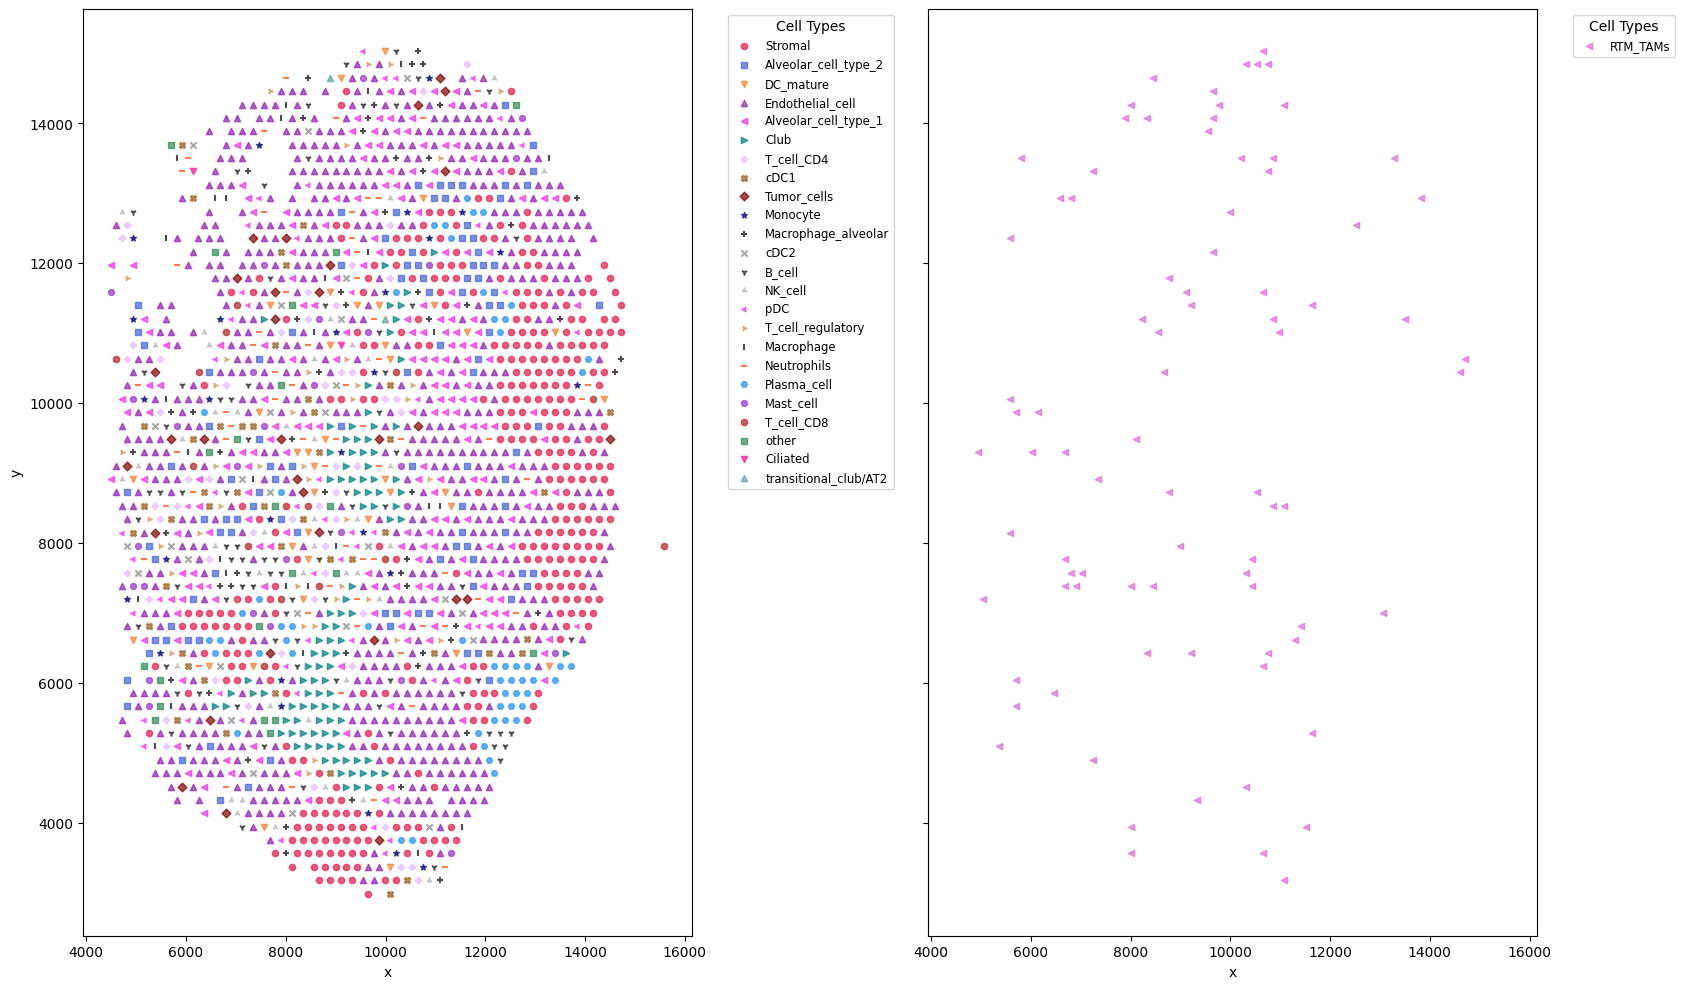

P19_B2


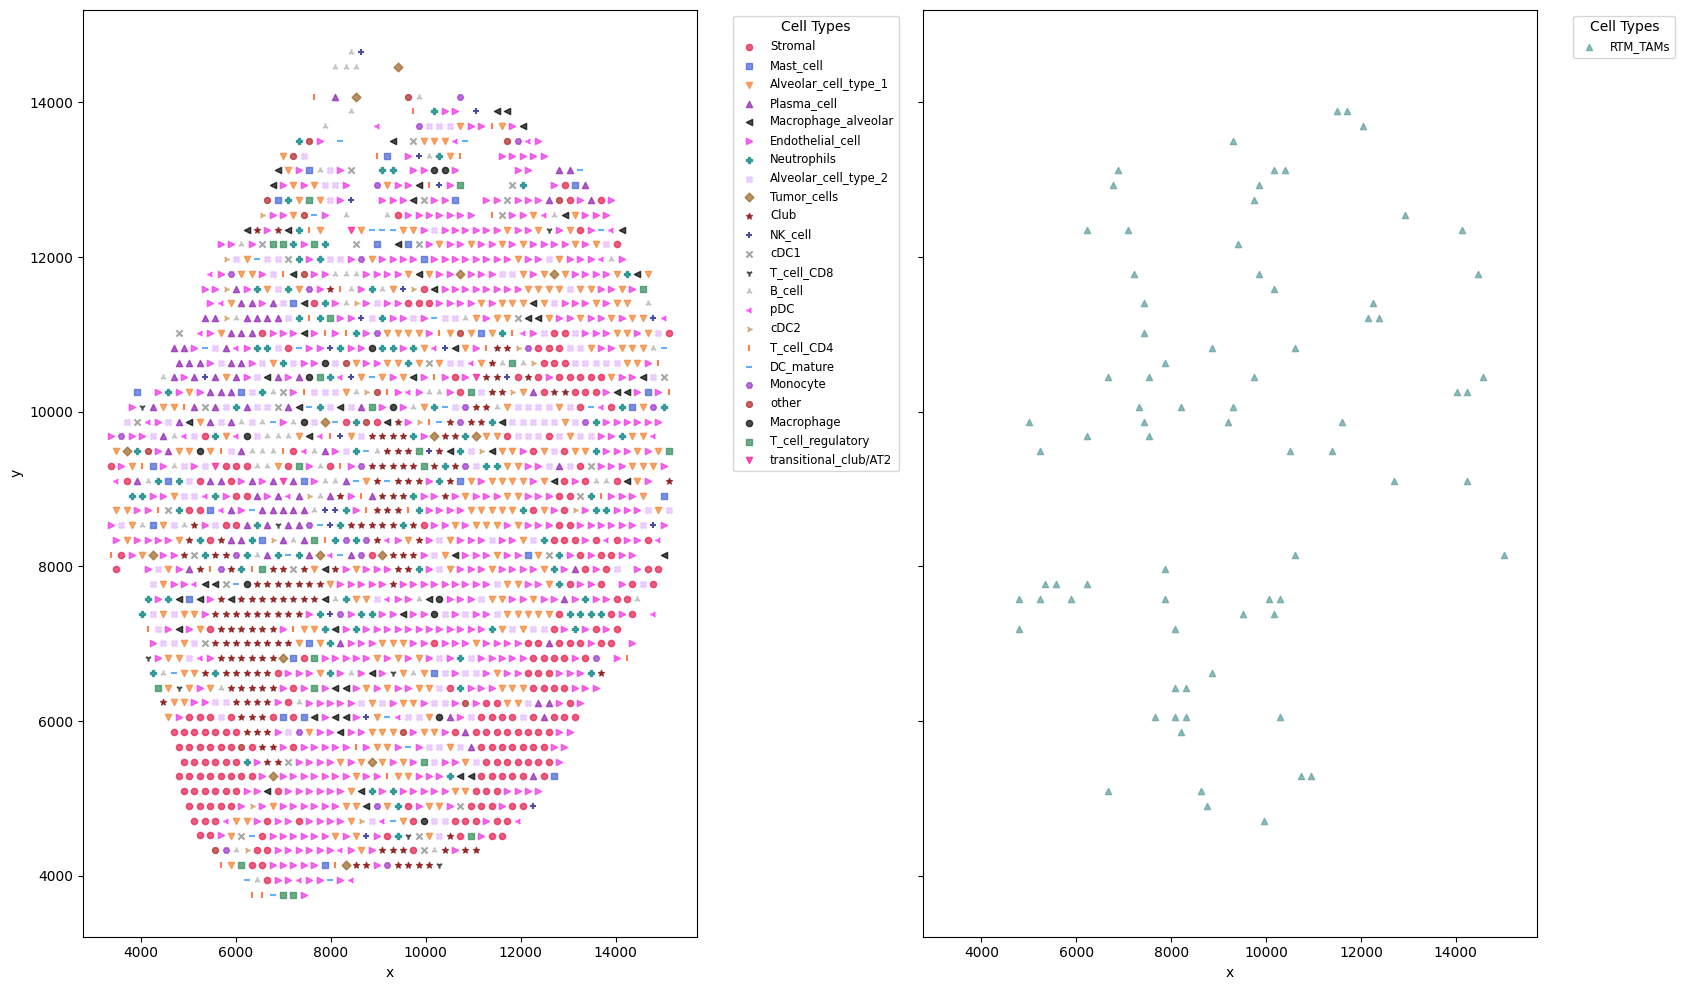

P11_B1


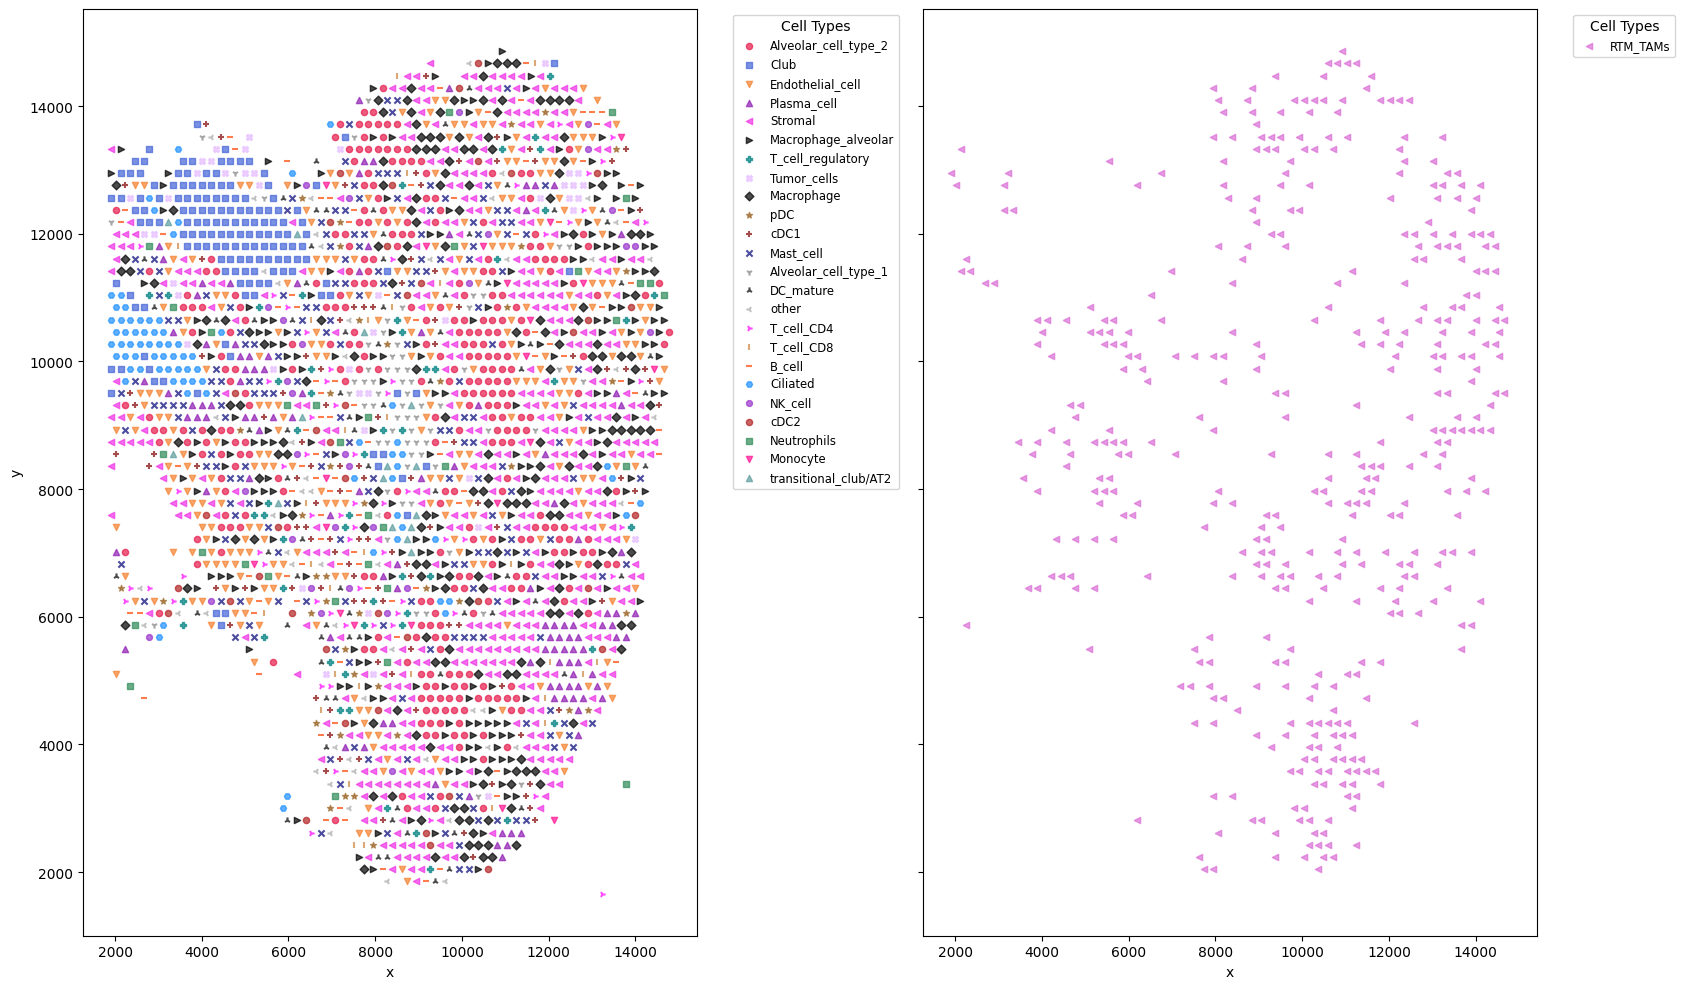

P11_B2


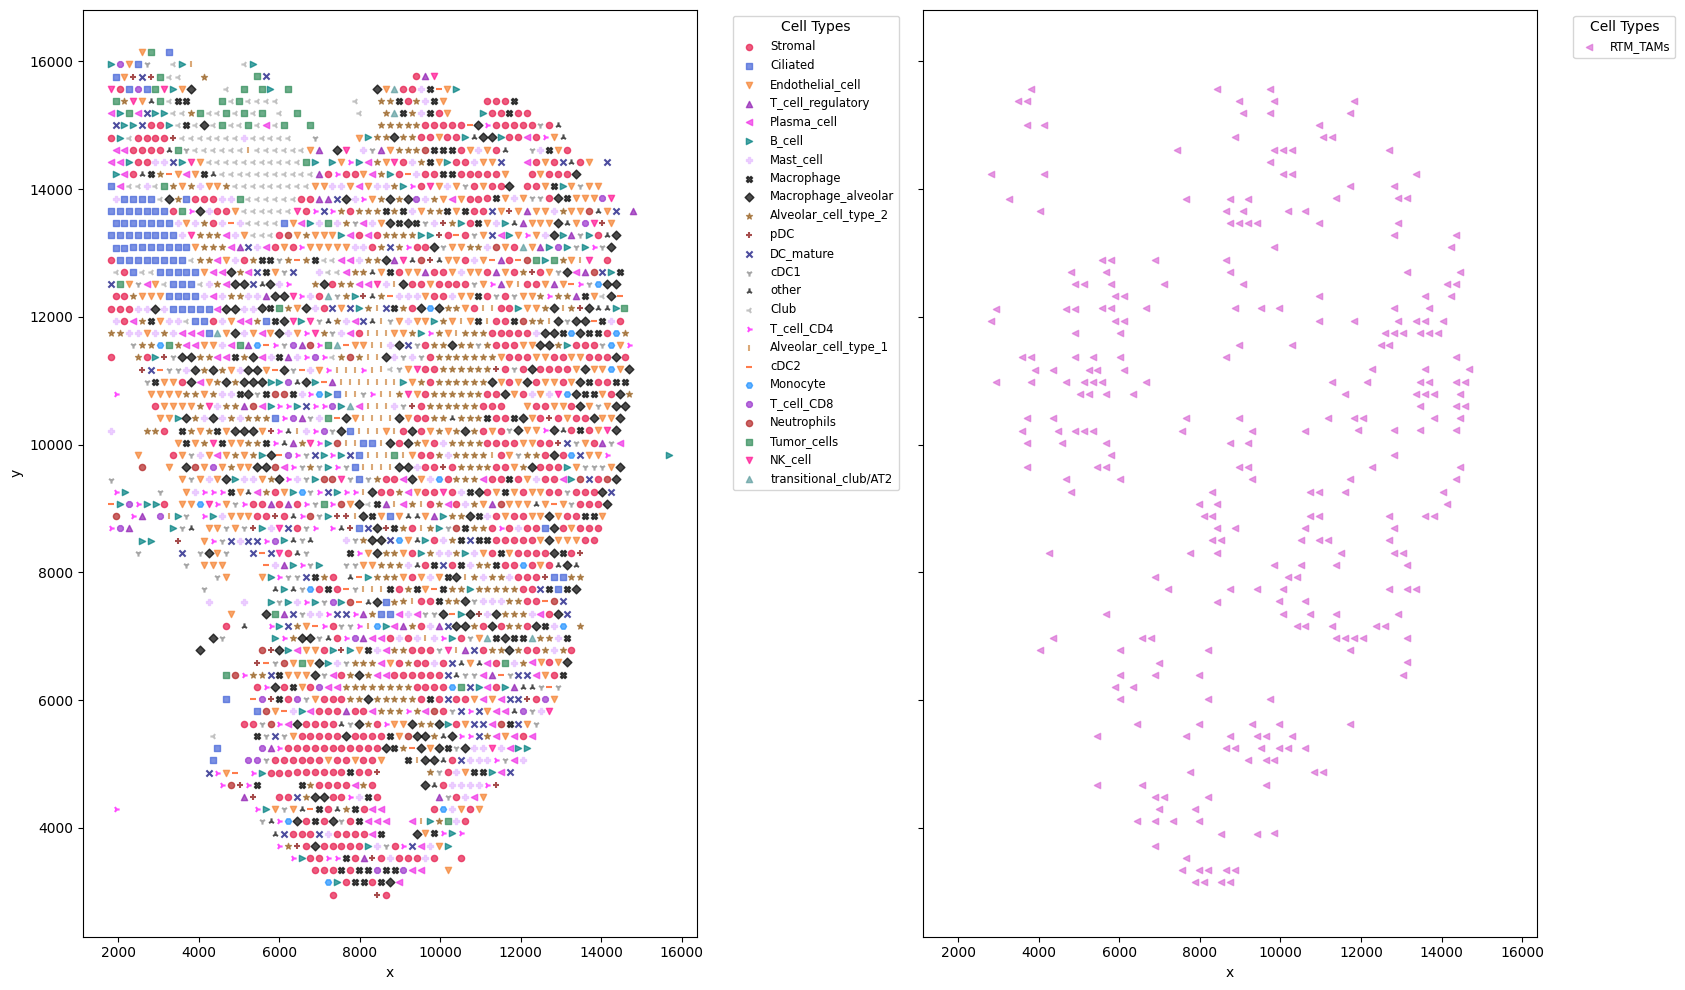

In [74]:
for patient in patients:
    print(ids[patient])
    task1_weights = slices[patient]["w"]
    task2_weights = slices_macrophages[patient]["w"]


    all_cell_types = pd.concat([task1_weights['max_w'], task2_weights['max_w']]).unique()

    #extend colors/markers if needed
    while len(colors) < len(all_cell_types):
        colors += colors

    while len(markers) < len(all_cell_types):
        markers += markers

    #assign marker and color maps
    marker_map = {}
    color_map = {}
    color_idx = 0
    for i, cell_type in enumerate(all_cell_types):
        marker_map[cell_type] = markers[i]
        if 'macrophage' in cell_type.lower(): # for task 1 i assign black color to macrophage spots
            color_map[cell_type] = 'black'
        else:
            color_map[cell_type] = colors[color_idx]
            color_idx += 1

    #create plots
    fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

    #plot for Task 1
    handles0, labels0 = [], []
    for cell_type in task1_weights['max_w'].unique():
        subset = task1_weights[task1_weights['max_w'] == cell_type]
        sc = axs[0].scatter(subset['x'], subset['y'],
                            marker=marker_map[cell_type],
                            color=color_map[cell_type],
                            s=20, 
                            alpha=0.7,
                            label=cell_type)
        handles0.append(sc)
        labels0.append(cell_type)
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    #plot for Task 2
    handles1, labels1 = [], []
    for cell_type in task2_weights['max_w'].unique():
        subset = task2_weights[task2_weights['max_w'] == cell_type]
        sc = axs[1].scatter(subset['x'], subset['y'],
                            marker=marker_map[cell_type],
                            color=color_map[cell_type],
                            s=20, 
                            alpha=0.7,
                            label=cell_type)
        handles1.append(sc)
        labels1.append(cell_type)
    axs[1].set_xlabel("x")

    #legends
    axs[0].legend(handles0, labels0, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title='Cell Types')
    axs[1].legend(handles1, labels1, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title='Cell Types')

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(f"{env}/plots/{ids[patient]}.pdf", format='pdf', bbox_inches='tight')
    plt.show()